# Econ 8185 - Computational Economics - HW1

João Lazzaro - santo279@umn.edu

# Growth Model:

$$\max_{\{c_t,x_t,l_t\}} \sum_{t=0}^\infty \big(\beta(1+\gamma_n)\big)^t [ log(c_t) +\varphi log(l_t)]$$
st:
$$ c_t+x_t = k_t^\theta\big((1+\gamma_z)^tz_t h_t)^{1-\theta}$$
$$ (1+\gamma_z)(1+\gamma_n) k_{t+1} = (1-\delta) k_t + x_t  $$
$$\log z_t = \rho \log z_{t-1}+\epsilon_t,\; \epsilon - N(0,\sigma^2)$$
$$ h_t+l_t=1 $$
$$c_t,x_t\geq 0 $$

Note the model above is the detrended version of the question model (I did not use hats, but they should be there).

# VFI 

For simplicity, we will use discretized state space for VFI. We will not assume any functional form (polynomial, splines, etc...) or interpolate the Value and Policy functions because our main concern is to understand the core of the methods. We probably could improve the speed or the stability of the algorithm doing these things.

Let's first define the utility function. The Non-negativity constraints are included by setting consumption negative when investment is negative. Thus, utility will be very low and these points will not be chosen. This constraint is optional.

In [1]:
function log_utility(c)
    if c<=0
        return -Inf #any value of negative consumtpion in the grid will be avoided
    else
        return log(c)
    end
end

log_utility (generic function with 1 method)

In [2]:
#Consumption with non-negative investment option
function consumption(k,z,h,γn=0,γz=0,ϕ=0,δ = 1,θ=1/3, InvestmentNonNegative = false)
    K=length(k)
    Z=length(z)
    H=length(h)
    #Preallocating memory. Note loops are fast in Julia.
    c=Array{Float64,4}(undef,K,Z,K,H)
    if InvestmentNonNegative == true #Non Negative investment
        for k0 in 1:K, k1 in 1:K
            x = (1+γz)*(1+γn)*k[k1]-(1-δ)*k[k0] #define the investment variable
            if x>=0     #If it is positive, we assign a normal value for consumption
                for z0 in 1:Z , h0 in 1:H
                    c[k0,z0,k1,h0]=k[k0]^θ *(z[z0]*h[h0])^(1-θ) + (1-δ)k[k0] - (1+γz)*(1+γn)k[k1]
                end
            else #If not, consumption is negative and will
                                      #be ruled out by Utility function
                c[k0,:,k1,:] = -ones(1,Z,1,H) 
            end
        end
    else #Standard case: investment can be negative
        for k0 in 1:K, z0 in 1:Z, k1 in 1:K, h0 in 1:H
            c[k0,z0,k1,h0]=k[k0]^θ *(z[z0]*h[h0])^(1-θ) + (1-δ)k[k0] - (1+γz)*(1+γn)k[k1]
        end
    end
    return c
end

function log_utility(c)
    if c<=0
        u = -Inf #any value of negative consumtpion in the grid will be avoided
    else
        u = log(c)
    end
    return u
end

log_utility (generic function with 1 method)

The Tauchen(1986) method for discretizing an AR(1) is below. See these lectures notes for a quick explanation of the method: http://www.econ.nyu.edu/user/violante/NYUTeaching/Macrotheory/Spring14/LectureNotes/lecture6_14.pdf

In [3]:
using Distributions
function Tauchen(ρ,σ,Y,μ = 0,m = 3)
    #This function is to discretize an AR(1) process following Tauchen(1986) method
    # y_{t+1} = μ + ρy_t + ϵ
    #ϵ~N(0,σ^2)
    #Y is the number of y states
if Y>1
    ybar = μ/(1-ρ)
    ymax= ybar + m*(σ^2/(1-ρ^2))^(1\2) #maximum y
    ymin= ybar - m*(σ^2/(1-ρ^2))^(1\2) #minimum y

    Δ = (ymax-ymin)/(Y-1)# #distance between each y
    y=ymin:Δ:ymax #vector of possible states of p

    d=Normal()

    pdfY=ones(Y,Y) #preallocate memory and create the transition matrix in the following loop
    for i in 1:Y
        pdfY[i,1]=cdf(d,(y[1] + Δ/2 -ρ*y[i]) / σ^0.5);
        pdfY[i,Y]=1-cdf(d,(y[Y] -Δ/2 - ρ*y[i]) / σ^0.5);
        for j in 2:Y-1
            pdfY[i,j]=cdf(d,(y[j] + Δ/2 - ρ*y[i])/σ^0.5) - cdf(d,(y[j] - Δ/2 - ρ*y[i]) / σ^0.5);
        end
    end
else
    y=μ
    pdfY=1
end
    
    return pdfY, y
end


Tauchen (generic function with 3 methods)

Finally, the main code for VFI is below:

In [4]:
function VFI(δ,θ,β,ρ,σ,μ,γn=0,γz=0,ϕ=0,K=500,kmax=10,kmin=0.01,Z=10,Xnneg=false,tol=10^(-8))
#parameters:
#δ - depreciation rate
#θ - capital share of output
#β - Discouting
#ρ - AR coefficient
#σ - AR shock SD
#ϕ - Labor parameter
#μ - AR(1) constant term
#K - number of gridpoints for capital AND LABOR
#Xnneg - Non negative investment (true or false)
#Z - number of productivity states
#kmax - maximum value for k (set low if no productivity shocks!)
#kmin - minimum value for k
#tol - convergence parameter
#grid for k
    k = range(kmin,stop = kmax, length=K)
    H=K
#grid for z
    Π, z = Tauchen(ρ,σ,Z,μ) #Transition matrix and values for log(z)
    z=exp.(z) #recover z
#grid for h
    h = range(0,stop = 1, length = K)
#utility Function:
if ϕ>0 #with labor

    #labu is the utility for satte value and control value
    labu = log_utility.(consumption(k,z,h,γn,γz,ϕ,δ,θ, Xnneg))

    #u is the utility after solving he static labor problem
    u = Array{Float64,3}(undef,K,Z,K)
    policy_h1 = Array{Int64,3}(undef,K,Z,K)
    for k0 in 1:K, z0 in 1:Z, k1 in 1:K
        u[k0,z0,k1], policy_h1[k0,z0,k1] = findmax(labu[k0,z0,k1,:] .+ ϕ.*log.(1 .- h))
    end
else #without labor
    
        u = log_utility.(consumption(k,z,h,γn,γz,ϕ,δ,θ, Xnneg)[:,:,:,end])
        policy_h = H.*trunc.(Int,ones(K,Z))
end
#utility values values, with or without nonnnegativity constraint on investment
#Note: Consumption and labu dimension is (K,Z,K,K)
#so they can potentially take a huge space in memory.
#Now we may forget about labor until we have the policy function for K

#Initial value function guess:
    V  = zeros(K,Z) 
    Vf = zeros(K,Z)

    #preallocation
    policy_k = Array{Int64,2}(undef,K,Z)
    #loop stuff
    distance = 1

#iterating on Value functions:
while distance >= tol
    #distance, Vf, policy_k
    Vf = copy(V) #save V to compare later

    #find the expected Vf: E[V(k,z')|z] = π(z1|z)*V(k,z1) +π(z2|z)*V(k,z2)
    EVf= (Π*Vf')'  #The transposing fix the dimensions so it works!

    for k0 in 1:K, z0 in 1:Z
        V[k0,z0] , policy_k[k0,z0] = findmax(u[k0,z0,:] .+ β *(1+γn)* EVf[:,z0]) #Bellman Equation
    end
 distance = maximum(abs.(V-Vf))

end
#Finally, find labor policy:
    if ϕ>0
        policy_h = Array{Int64,2}(undef,K,Z)
        for k0 in 1:K, z0 in 1:Z
            policy_h[k0,z0] = policy_h1[k0,z0,policy_k[k0,z0]]
        end
    end

    return V, policy_k,policy_h, k,h, z, Π
end


VFI (generic function with 10 methods)

## No exogenous variables

We consider first the case in which $z_t=1,\;\forall t$. Hence, the parameters are:

In [5]:
using Plots
δ = 1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0    #Productivitu growth rate

Xnneg = true #Non negative investment if true

#grid for k

K = 251 #number of gridpoints for capital
kmax = 1/5 # maximum value for k (set low if no productivity shocks!)
kmin = 0.01 #minimum value for k
#grid for z
Z = 1 #number of productivity states

V, policy_k,policy_h, k,h, z, Π = VFI(δ,θ,β,ρ,σ,μ,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg);

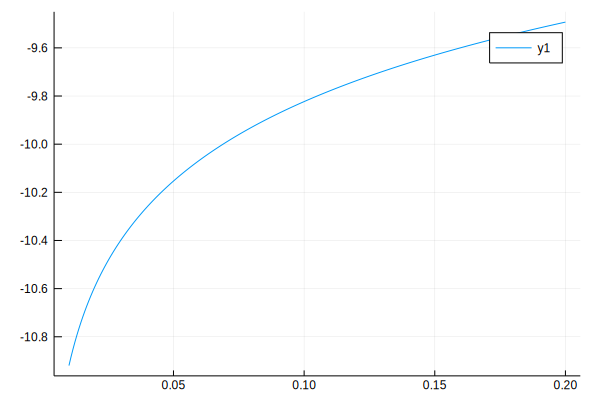

In [6]:
using Plots
plot(k,V) #plot the value function

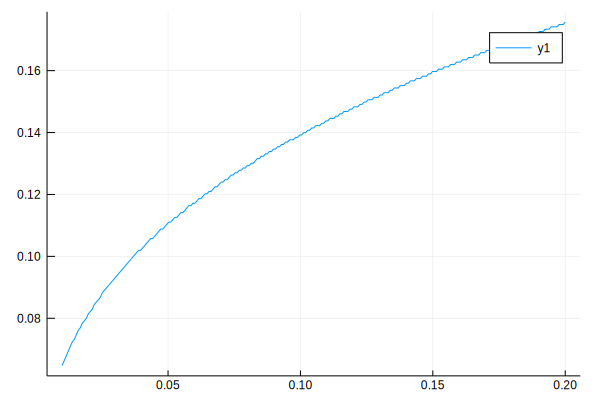

In [7]:
plot(k,k[policy_k]) #plot the capital policy function


As expected, labor decision is constant (does not depend on capital):

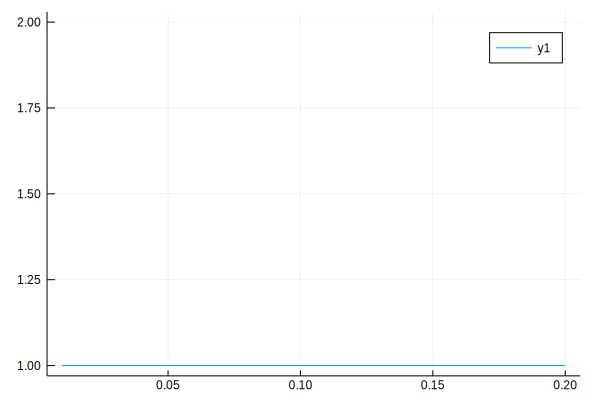

In [8]:
plot(k,h[policy_h])

To test if our numerical approximation is good enough, we plot below the difference between the theoretical and the numerical policy functions

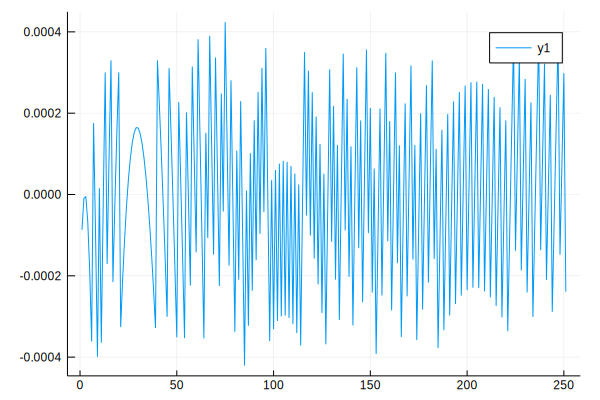

In [9]:
theoretical = θ*β*k.^θ*h[policy_h[1]]^(1-θ)
difference = theoretical - k[policy_k]
plot(difference)

As we can see, the precision is up to the 3rd digit

In [10]:
maximum(abs.(difference))


0.00042397703393291797

## Adding Shocks

The main difference now is that we allow for more states of z. It will be an AR(1) and we will discretize the state space following Tauchen(1986). We consider a world with 40 productivity states. In our baseline Scenario, there is full depreciation, no growth and labor supply should be inelastic:

In [11]:
using Plots
δ = 1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0    #Productivitu growth rate

Xnneg = true #Non negative investment

#grid for k

K = 200 #number of gridpoints for capital
kmax = 1/5 # maximum value for k (set low if no productivity shocks!)
kmin = 0.01 #minimum value for k
#grid for z
Z = 40 #number of productivity states

V, policy_k,policy_h, k,h, z, Π = VFI(δ,θ,β,ρ,σ,μ,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg);

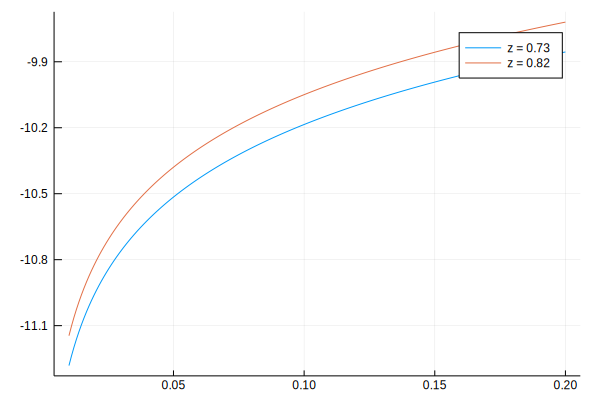

In [12]:
using Printf
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [V[:,2],V[:,9]]
plot(k, data, label = labels) 
#plot the Value function griven 2 level of z

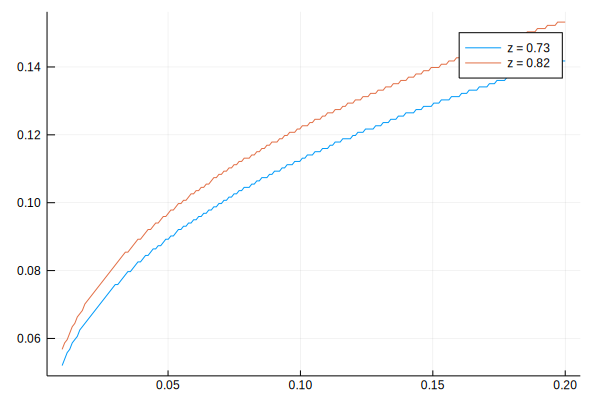

In [13]:

labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [k[policy_k[:,2]],k[policy_k[:,9]]]
plot(k, data, label = labels) 
#plot the capital policy function given 2 level of z

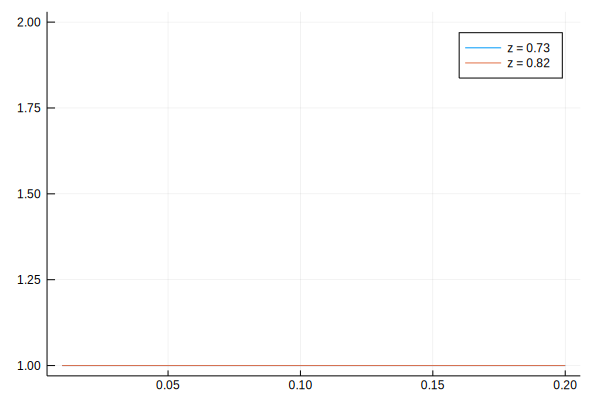

In [14]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [h[policy_h[:,3]],h[policy_h[:,9]]]
plot(k, data, label = labels) 
#plot the Labor policy function given 2 level of z. Note, labor choice is constant!

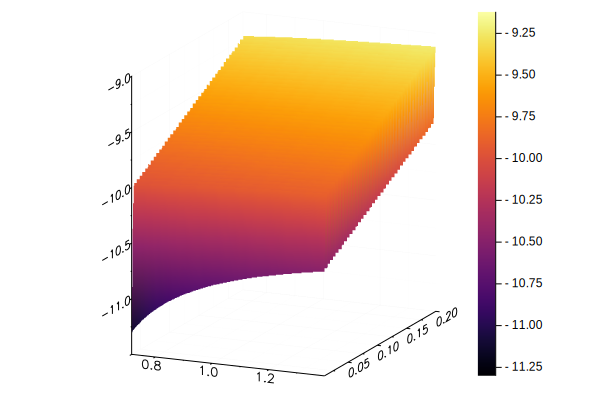

In [15]:
Plots.surface(z,k,V') #Value function in 3d

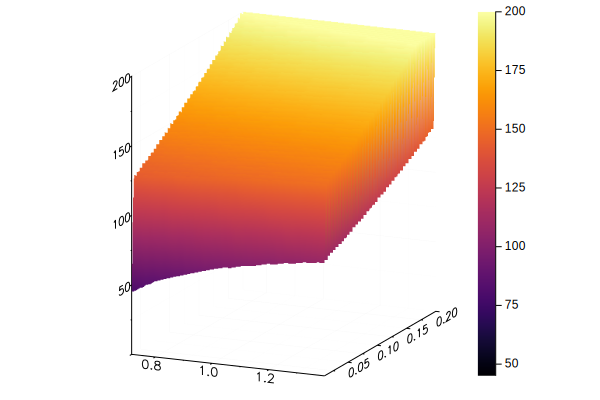

In [16]:
Plots.surface(z,k,policy_k') #Capital Policy function in 3d

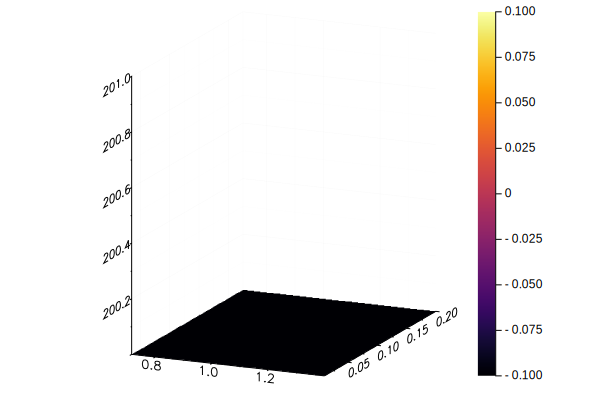

In [17]:
Plots.surface(z,k,policy_h') #Labor Policy function in 3d 

# Including depreciation

We keep the same parameters as before, but now $\delta = 0.1$. Note that we had to increase the range of the capital grid.

In [18]:
using Plots
δ = 0.1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0    #Productivitu growth rate

Xnneg = true #Non negative investment

#grid for k

K = 200 #number of gridpoints for capital
kmax = 1 # maximum value for k (set low if no productivity shocks!)
kmin = 0.01 #minimum value for k
#grid for z
Z = 40 #number of productivity states

V, policy_k,policy_h, k,h, z, Π = VFI(δ,θ,β,ρ,σ,μ,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg);

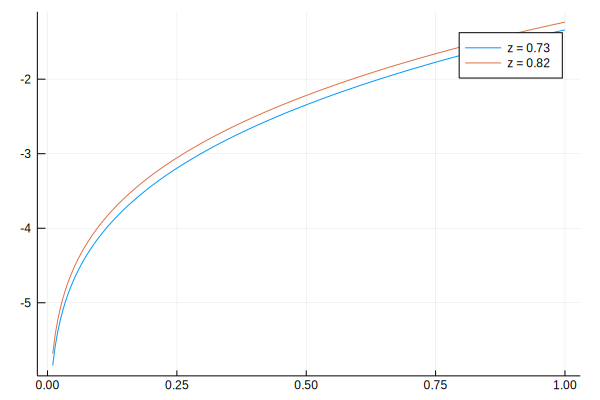

In [19]:
using Printf
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [V[:,2],V[:,9]]
plot(k, data, label = labels) 
#plot the Value function griven 2 level of z

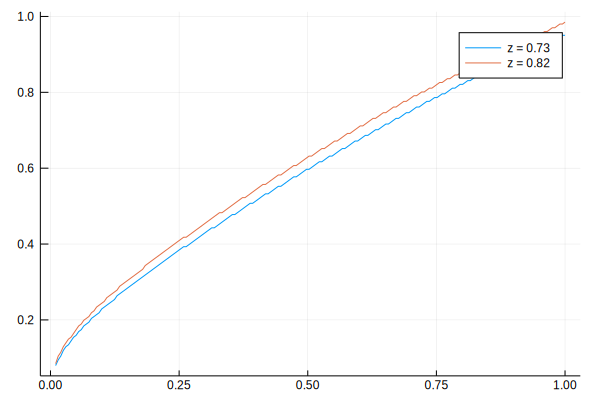

In [20]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [k[policy_k[:,2]],k[policy_k[:,9]]]
plot(k, data, label = labels) 
#plot the capital policy function given 2 level of z

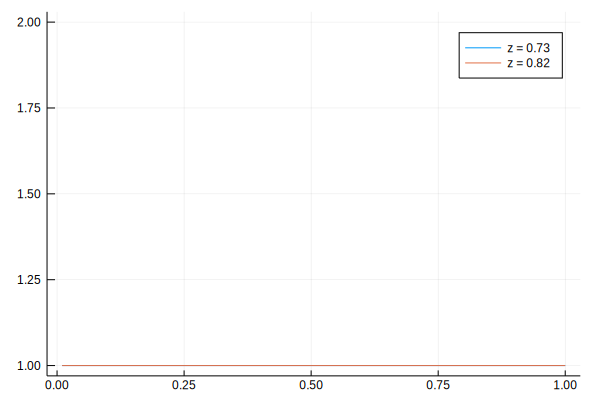

In [21]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [h[policy_h[:,3]],h[policy_h[:,9]]]
plot(k, data, label = labels) 
#plot the Labor policy function given 2 level of z. Note, labor choice is constant!

## Including technology growth

Now, we keep everything from above and set $\gamma_z = 0.05$. Note that the Value FUnctionction has shifted below.

In [22]:
using Plots
δ = 0.1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0.25   #Productivitu growth rate

Xnneg = true #Non negative investment

#grid for k

K = 200 #number of gridpoints for capital
kmax = 1 # maximum value for k (sbet low if no productivity shocks!)
kmin = 0.01 #minimum value for k
#grid for z
Z = 40 #number of productivity states

V, policy_k,policy_h, k,h, z, Π = VFI(δ,θ,β,ρ,σ,μ,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg);

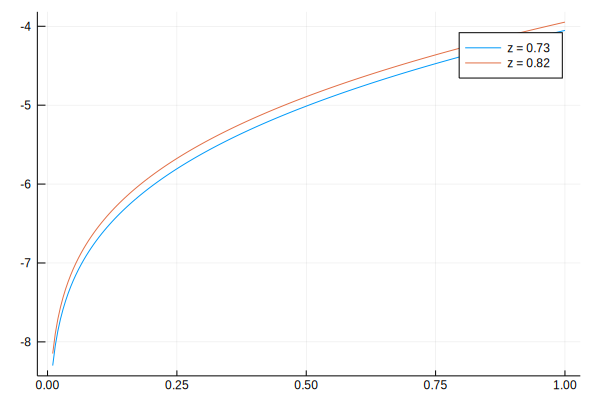

In [23]:
using Printf
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [V[:,2],V[:,9]]
plot(k, data, label = labels) 
#plot the Value function griven 2 level of z

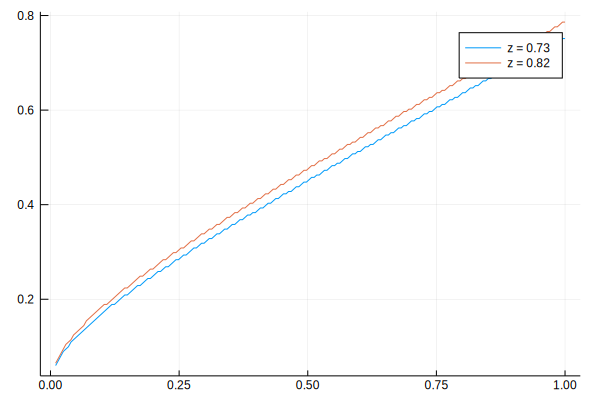

In [24]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [k[policy_k[:,2]],k[policy_k[:,9]]]
plot(k, data, label = labels) 
#plot the capital policy function given 2 level of z

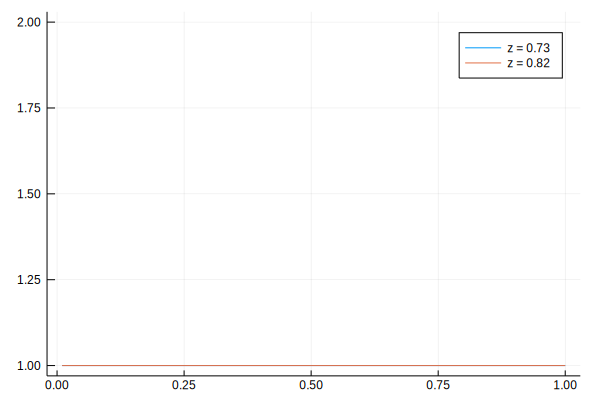

In [25]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [h[policy_h[:,3]],h[policy_h[:,9]]]
plot(k, data, label = labels) 
#plot the Labor policy function given 2 level of z. Note, labor choice is constant!

## Including population growth

Now, we keep everything from above and set $\gamma_z = 0.05$. Note that the Value FUnctionction has shifted below.

In [26]:
using Plots
δ = 0.1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0.25   #Productivitu growth rate

Xnneg = true #Non negative investment

#grid for k

K = 200 #number of gridpoints for capital
kmax = 1 # maximum value for k (sbet low if no productivity shocks!)
kmin = 0.01 #minimum value for k
#grid for z
Z = 40 #number of productivity states

V, policy_k,policy_h, k,h, z, Π = VFI(δ,θ,β,ρ,σ,μ,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg);

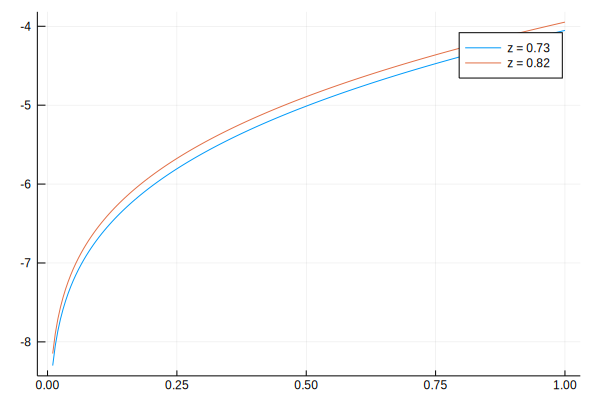

In [27]:
using Printf
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [V[:,2],V[:,9]]
plot(k, data, label = labels) 
#plot the Value function griven 2 level of z

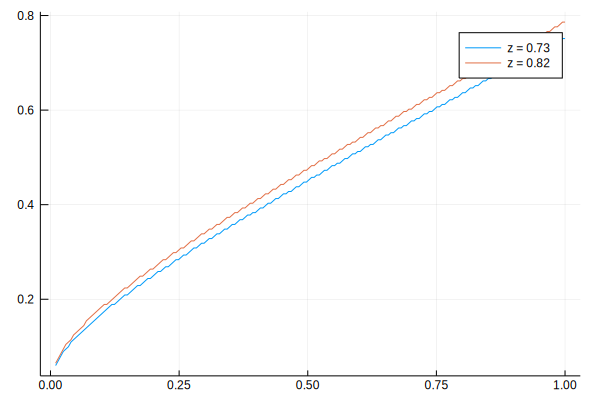

In [28]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [k[policy_k[:,2]],k[policy_k[:,9]]]
plot(k, data, label = labels) 
#plot the capital policy function given 2 level of z

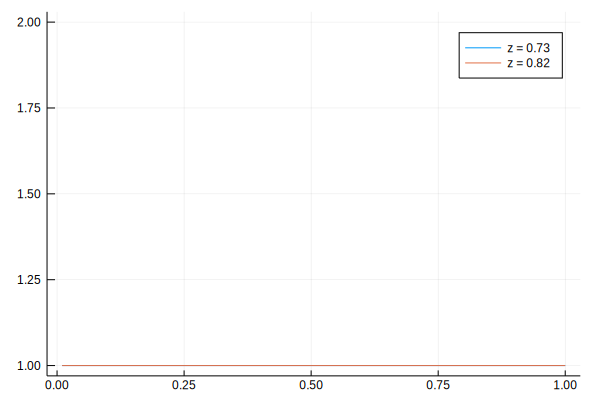

In [29]:
labels = [@sprintf("z = %.2f",z[2]),@sprintf("z = %.2f",z[9]) ]
data = [h[policy_h[:,3]],h[policy_h[:,9]]]
plot(k, data, label = labels) 
#plot the Labor policy function given 2 level of z. Note, labor choice is constant!

## LQ APROXIMATION

Let's summarize our Sate and control variables in the LQ standard notation:


$$\max_{\{k_{t+1},h_t\}} \sum_{t=0}^\infty (\beta (1+\gamma_n))^t [ \log(k_t^\theta(z_t h_t)^{1-\theta}+(1-\delta) k_t - (1+\gamma_n)(1+\gamma_z)k_{t+1}) +\varphi \log(1-h_t)]$$
st:


$$\log z_t = \rho \log z_{t-1}+\epsilon_t,\; \epsilon - N(0,\sigma^2)$$


$$X_t = \begin{bmatrix}k_t\\\ \log z_t \\ 1\end{bmatrix}$$

$$A = \begin{bmatrix}0 & 0 & 0 \\ 0 & \rho & 0 \\ 0 & 0 & 1 \  \end{bmatrix}$$

$$u_t = \begin{bmatrix}k_{t+1}\\\ h_t \end{bmatrix}$$

$$B = \begin{bmatrix} 1 & 0  \\ 0 & 0  \\ 0 & 0   \ \end{bmatrix}$$

$$C = \begin{bmatrix} 0 \\ 1 \\ 0\end{bmatrix}$$

Note that the objctive function is not linear. So, we will linearize around of the Steady State. First, let's find the Steady State values through the FOCs:

FOC:
$$z_{ss} = \exp(0) = 1$$
$$k_{ss}:\; (\beta(1+\gamma_n))^t \frac{(1+\gamma_n)(1+\gamma_z)}{k_{ss}^\theta(z_{ss} h_{ss})^{1-\theta}+(1-\delta) k_{ss} - (1+\gamma_n)(1+\gamma_z)k_{ss}} = (\beta(1+\gamma_n))^{t+1}\frac{\theta k_{ss}^{\theta-1}(z_{ss} h_{ss})^{1-\theta} +(1-\delta)}{k_{ss}^\theta(z_{ss} h_{ss})^{1-\theta}+(1-\delta) k_{ss} - (1+\gamma_n)(1+\gamma_z)k_{ss}}$$



$$\implies k_{ss} = \big(\frac{\beta \theta}{(1+\gamma_z)- \beta(1-\delta)}\big)^{\frac{1}{1-\theta}} h_{ss}$$

$$ h_{ss}:\; \frac{k_{ss}^\theta(z_{ss} h_{ss})^{-\theta}z_{ss}(1-\theta)}{k_{ss}^\theta(z_{ss} h_{ss})^{1-\theta}+(1-\delta) k_{ss} - (1+\gamma_n)(1+\gamma_z)k_{ss}} = \varphi \frac{1}{1-h_{ss}} $$


Even though we found the closed form solutions for the SS, in my code I find hem via a numerical solver.
We need now to take 2nd order Taylor expansion of the utility function around the SS. As a reminder, a second order Taylor around $a$ expansion is given by:

$$f(x) \approx f(a) +(x-a)' \nabla f(a) +\frac{1}{2} (x-a)' H(a)(x-a)$$

Where $\nabla f$ is the Gradient and $H$ is the Hessian of $f$. With the help of a symbolic solver, we get:

Recall that we want write the function $u$ in the following fashion:

$$u(X_t) \approx X_t'QX_t +u_t' R u_t +2u_t' W X_t = \begin{bmatrix}X_t \\ u_t \  \end{bmatrix}' M \begin{bmatrix}X_t \\ u_t \  \end{bmatrix}$$





Where  $$M:= \begin{bmatrix} Q & W  \\ W' &  R   \end{bmatrix}$$


Let $v_t := [X_t\;\; u_t]'$, and $e$ is such that $e'v_t=1,\forall t$. According to Sargent and Ljunqvist book:



$$M = e\big[u(v_{ss}) - \nabla u(v_{ss})' v_{ss} +\frac{1}{2} v_{ss}' Hu(v_{ss}) v_{ss}\big]e' + \frac{1}{2} \big (\nabla u(v_{ss}) e' - e v_{ss}' Hu(v_{ss}) - Hu(v_{ss})v_{ss} e' + e \nabla u(v_{ss})' \big) +\frac{1}{2} Hu(v_{ss})   $$

Hence we have all the elements to iterate the Riccati equation, as in the lecture notes. We do it below:

In [16]:
#This code defines a fuction to iterate the Riccati equation as in Ellen's notes

using LinearAlgebra
function Riccati(A,B,Q,R,W,β,γ1=10^(-5),γ2=10^(-5),p=1)

#γ s are the convergece parameter ad p is the matrix p norm we are usig
#Guess initial value for P

        
    
P=ones(size(A)[2],size(A)[1])
F=ones(size(R)[1],size(W)[1])

#initialize loop:
distP = 10; distF = 10; i=1

#see the notes to understand this. It is basically a translation from there to Julia
while distP>=γ1.*opnorm(P,p) || distF>=γ2*opnorm(F,p)
    #global P, F, i, distP, distF, P1, F1
    P1 = Q + A'*P*A - A'*P*B*inv(R+B'* P *B)*B'*P*A
    F1 = inv(R+B'*P*B) * B' * P * A
    distP = opnorm(P1-P,p)
    distF = opnorm(F1-F,p)
    i=i+1

    P=copy(P1)
    F = copy(F1)
end

F = F+inv(R)*W'

return P, F
end


Riccati (generic function with 4 methods)

In [47]:
#This script appoximates a discouted utility fnction via 2nd order Taylo Expansion
#We need to find matrices Q,R, W such that
#U(X,u)≈X′QX+u′Ru+2u′WX=[X u]′M[X u]
#Where X is a vector of states variables and u of cotrol variables

using Plots
using ForwardDiff
using NLsolve


#Parameters:
δ = 0.5    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0    #Productivitu growth rate

Xnneg = true #Non negative investment


#return function is the utility function:
#Euler Equation:
#using NLsolve we need to defie the Euler equation as functions
function ee!(eq, x)
    h=(x[2])
    k=(x[1])
    eq[1] = k - (β*θ / ((1+γz)-β*(1-δ)))^(1/(1-θ)) *h
    eq[2] = (1-h)*((1-θ) *k^θ * h^(-θ)) - ϕ*(k^θ * h^(1-θ) +(1-δ)*k - (1+γn)*(1+γz)k)
end
S = nlsolve(ee!, [0.1,0.8],ftol = :1.0e-9, method = :trust_region , autoscale = true)
#kss=exp(μ)*((1-β*(1-δ))/(θ*β))^(1/(θ-1))
kss = S.zero[1] #get the SS values 
hss = S.zero[2]
zss = 0 #SS of the shocks is just 0 ote that z goes into the utility funcion as exp(z)

#Utility function
#REMEMBER: V is the [X u]' Vector, hence [k0 z0 1 k1 h0]'
#X is the state variables vector (and a constant) while u is the cotrol variables vector
function u(x::Vector)
    c = x[1]^θ *(exp(x[2])*x[5])^(1-θ) +(1-δ)*x[1] - (1+γn)*(1+γz)*x[4]
    investment =  (1+γn)*(1+γz)*x[4] - (1-δ)*x[1]
    if c<=0
        u = -Inf #any value of negative consumtpion in the grid will be avoided
    elseif investment <0
        u=-Inf #nonnegative investment constraint
        
    elseif ϕ >0
        u = log(c) + ϕ * log(1-x[5])
    else
        u=log(c)
    end
    return u
end

#vector with SS variables And the consant term
vss= [kss,zss,1,kss,hss] 
#Find the Gradient and Hessian AT THE SS
uss=u(vss)
∇u = ForwardDiff.gradient(u,vss)
Hu = ForwardDiff.hessian(u,vss)

Xss = vss[1:3]
Uss = vss[4:5]

#We are looking for a matrix M such that u(vss) = vss'M vss
#Applying Sargent's Formula:
e = [0;0;1;0;0] #thus e'v=1


M = e.* (uss - ∇u'*vss .+ (0.5 .* vss' *Hu *vss) ) * e' +
    0.5 *(∇u * e' - e * vss' * Hu - Hu*vss*e' +e* ∇u') +
    0.5 * Hu
#Translating M into the Matrices we need:
Q = M[1:3,1:3] 
W = M[1:3,4:5]
R = M[4:5,4:5]

A = [0 0 0 ;0 ρ 0 ; 0 0 1]
B = [1  0; 0  0 ; 0 0]
C = [0 ; 1 ; 0]

#Mapping to the problem without discounting (1 VARIABLES ARE ~ IN LECTURE NOTES)
A1 = sqrt(β) *(A -B*inv(R)*W')
B1 = sqrt(β) *B
Q1 = Q- W*inv(R)*W' 


P, F = Riccati(A1,B1,Q1,R,W,β)

F1= F-inv(R) *W'

isposdef(Q)


false

In [48]:
P


3×3 Array{Float64,2}:
 -2.00266  -0.16549     1.61352 
 -0.16549   0.0924731   0.966667
  1.61352   0.966667   -2.51477 

Below we check if ou appoximation returns the same value at the SS as the oigial functios:

In [49]:
Xss' * Q *Xss +Uss' *R * Uss + 2*Xss' *W *Uss

-0.6215216329036963

In [50]:
u(vss)

-0.6215216329036962

In plots:

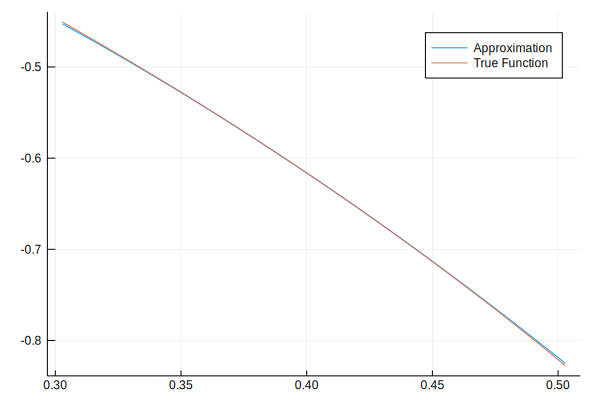

In [51]:
#STATE CAPITAL
using Printf

K=300
fun1 = ones(K)
k=range( kss-0.1,stop = kss+0.1, length=K)
fun2=ones(K)
for k1 in 1:K
    fun1[k1] = [kss,zss,1,k[k1],hss]' * M * [kss,zss,1,k[k1],hss]
    fun2[k1] = u([kss,zss,1,k[k1],hss])
end

labels = [@sprintf("Approximation"),@sprintf("True Function") ]
plot(k,[fun1,fun2],label = labels)

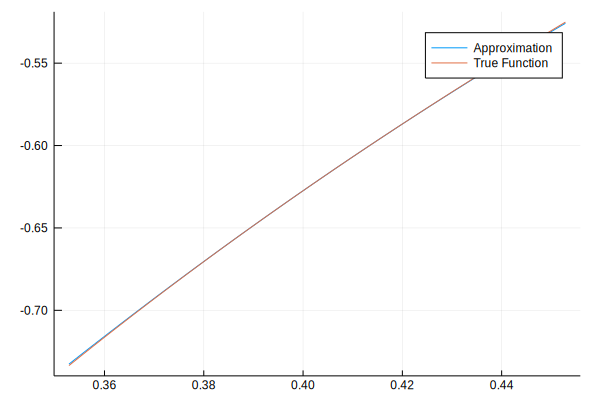

In [52]:
#CHOICE CAPITAL
K=300
fun1 = ones(K)
kmin=kss-0.05
kmax=kss+0.05
k=range( kmin,stop = kmax, length=K)
fun1=ones(K)
for k1 in 1:K
    fun1[k1] = [k[k1],zss,1,kss,hss]' * M * [k[k1],zss,1,kss,hss]
    fun2[k1] = u([k[k1],zss,1,kss,hss])
end

labels = [@sprintf("Approximation"),@sprintf("True Function") ]
plot(k,[fun1,fun2],label = labels)

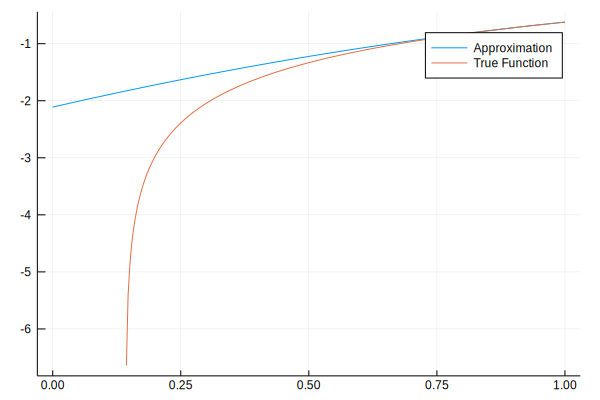

In [53]:
#LABOR
H=300
fun1 = ones(H)
h=range( 0,stop = 1, length=K)
fun2=ones(K)
for k1 in 1:K
    fun1[k1] = [kss,zss,1,kss,h[k1]]' * M * [kss,zss,1,kss,h[k1]]
    fun2[k1] = u([kss,zss,1,kss,h[k1]])
end

labels = [@sprintf("Approximation"),@sprintf("True Function") ]
plot(h,[fun1,fun2],label = labels)

Now, with the F matrix we can generate the time series for the state variables according to: $X_{t+1} = (A-BF)X_t +C \epsilon_{t+1}$

And the control variables: $u_t= -FX_t$

Below, we plot the time series for capital with the steady state being the initial state:

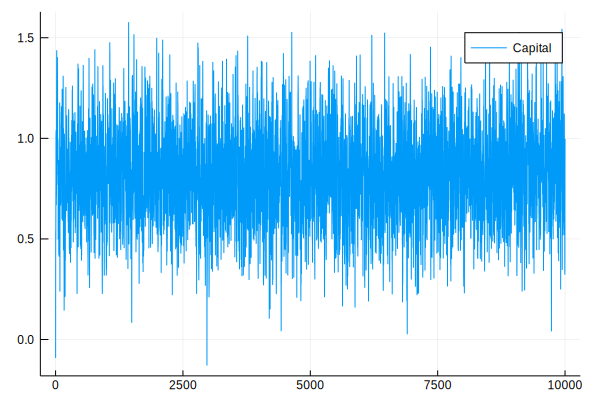

In [60]:
T= 10000 #simulation time
ϵ = σ .* randn(T) #Normal distributed shocks
z =zeros(T) #initial state is 0 - the ss
k = (kss+σ *randn())*ones(T) #initial state is not the ss

X = [k';z';ones(T)']
X1= copy(X)
U = ones(2,T)
U[:,1] = -F1*X[:,1]
U1=copy(U)
for t=1:T-1
    X[:,t+1] = ((A-B*F)*X[:,t] + C.* ϵ[t+1])
    X1[:,t+1]= β^(1/2)*X[:,t+1]
    U[:,t+1] = -F* X[:,t+1]
    U1[:,t+1] = -F1* X1[:,t+1]
end

k = X[1,:]
h = U[2,:]
z = X[2,:]

labels = "Capital"
plot(k,label = labels)


In [61]:
kss

0.4028448795687259

In [59]:
using Statistics
mean(k)

0.0006547825996488219

As we can see above, capital is floating close to the SS. And below, labor converges to the SS and is constant.

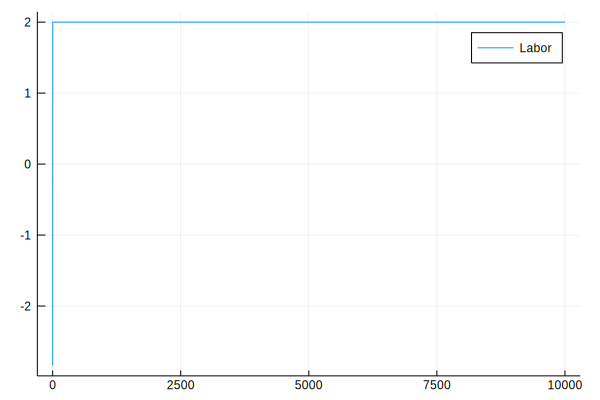

In [41]:
labels = "Labor"
plot(h,label = labels)


In [42]:
hss

1.0000000000003775

## Vaughan's Method

In Vaughan's Method, we calculate the Matrix P in another, but equivalent and faster, way:  

$$P=V_{22}V_{12}^{-1}$$

Where $V$ comes from the decomposition of the coefficients matrix:

$$\mathcal{F} = \begin{bmatrix} \tilde{A}^{-1} & \tilde{A}^{-1} \tilde{B} R^{-1} \tilde{B}'   \\ \tilde{Q} \tilde{A}^{-1} &   \tilde{Q} \tilde{A}^{-1} \tilde{B} R ^{-1} \tilde{B}' +\tilde{A}'  \end{bmatrix} = \begin{bmatrix} V_{11} & V_{12}   \\ V_{21} &   V_{22}  \end{bmatrix} \begin{bmatrix} \Lambda^{-1} & 0   \\ 0 &   \Lambda  \end{bmatrix} \begin{bmatrix} V_{11} & V_{12}   \\ V_{21} &   V_{22}  \end{bmatrix}^{-1}$$

Note that $\Lambda$, a matrix with the eigenvalues outside of the unit circle, position is different from the lecutres note because Julia orders it this way.

The code below does that, and then we simulate capital time series and show that everything should be working.

In [43]:
#This function implements the Vaughan's method 

function Vaughan(A,B,Q,R,W)
    L=size(A)[1]
    ℋ = [inv(A)  inv(A)*B*inv(R)*B';Q*inv(A) Q*inv(A)*B*inv(R)*B'+A'] #This is the coefficient matrix.
    V= eigen(ℋ).vectors #Take the eigenvector matrix The first 
    #Note that Julia puts the eigenvalues out of the unit circle in the bottom of the matrix, 
    #while in the lecture notes they are at the top
    P = V[L+1:end,L+1:end] * inv(V[1:L,L+1:end])  #Get the P matrix
    F=inv(R+B'*P*B) * B' * P * A +inv(R)*W' #Finally, compute F
    return P, F
end
    
    
    

Vaughan (generic function with 1 method)

In [45]:
#This script appoximates a discouted utility fnction via 2nd order Taylo Expansion
#We need to find matrices Q,R, W such that
#U(X,u)≈X′QX+u′Ru+2u′WX=[X u]′M[X u]
#Where X is a vector of states variables and u of cotrol variables

using Plots
using ForwardDiff
using NLsolve


#Parameters:
δ = 1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0    #Productivitu growth rate

Xnneg = true #Non negative investment


#return function is the utility function:
#Euler Equation:
#using NLsolve we need to defie the Euler equation as functions
function ee!(eq, x)
    h=(x[2])
    k=(x[1])
    eq[1] = k - (β*θ / ((1+γz)-β*(1-δ)))^(1/(1-θ)) *h
    eq[2] = (1-h)*((1-θ) *k^θ * h^(-θ)) - ϕ*(k^θ * h^(1-θ) +(1-δ)*k - (1+γn)*(1+γz)k)
end
S = nlsolve(ee!, [0.1,0.8],ftol = :1.0e-9, method = :trust_region , autoscale = true)
#kss=exp(μ)*((1-β*(1-δ))/(θ*β))^(1/(θ-1))
kss = S.zero[1] #get the SS values 
hss = S.zero[2]
zss = 0 #SS of the shocks is just 0 ote that z goes into the utility funcion as exp(z)

#Utility function
#REMEMBER: V is the [X u]' Vector, hence [k0 z0 1 k1 h0]'
#X is the state variables vector (and a constant) while u is the cotrol variables vector
function u(x::Vector)
    c = x[1]^θ *(exp(x[2])*x[5])^(1-θ) +(1-δ)*x[1] - (1+γn)*(1+γz)*x[4]
    investment =  (1+γn)*(1+γz)*x[4] - (1-δ)*x[1]
    if c<=0
        u = -Inf #any value of negative consumtpion in the grid will be avoided
    elseif investment <0
        u=-Inf #nonnegative investment constraint
        
    elseif ϕ >0
        u = log(c) + ϕ * log(1-x[5])
    else
        u=log(c)
    end
    return u
end

#vector with SS variables And the consant term
vss= [kss,zss,1,kss,hss] 
#Find the Gradient and Hessian AT THE SS
uss=u(vss)
∇u = ForwardDiff.gradient(u,vss)
Hu = ForwardDiff.hessian(u,vss)

Xss = vss[1:3]
Uss = vss[4:5]

#We are looking for a matrix M such that u(vss) = vss'M vss
#Applying Sargent's Formula:
e = [0;0;1;0;0] #thus e'v=1


M = e.* (uss - ∇u'*vss .+ (0.5 .* vss' *Hu *vss) ) * e' +
    0.5 *(∇u * e' - e * vss' * Hu - Hu*vss*e' +e* ∇u') +
    0.5 * Hu

#Translating M into the Matrices we need:
Q = M[1:3,1:3] 
W = M[1:3,4:5]
R = M[4:5,4:5]

A = [0 0 0 ;0 ρ 0 ; 0 0 1]
B = [1  0; 0  0 ; 0 0]
C = [0 ; 1 ; 0]

#Mapping to the problem without discounting (1 VARIABLES ARE tilde IN LECTURE NOTES)
A1 = sqrt(β) *(A -B*inv(R)*W')
B1 = sqrt(β) *B
Q1 = Q- W*inv(R)*W' 


Pv,Fv = Vaughan(A1,B1,Q1,R,W)
F1v= Fv-inv(R) *W'


UndefVarError: UndefVarError: Vaughan not defined

In [46]:
T= 10000 #simulation time
ϵ = σ .* randn(T) #Normal distributed shocks
z =zeros(T) #initial state is 0 - the ss
k = (kss+σ *randn())*ones(T) #initial state is not the ss

X = [k';z';ones(T)']
X1= copy(X)
U = ones(2,T)
U[:,1] = -F1v*X[:,1]
U1=copy(U)
for t=1:T-1
    X[:,t+1] = ((A-B*Fv)*X[:,t] + C.* ϵ[t+1])
    X1[:,t+1]= β^(1/2)*X[:,t+1]
    U[:,t+1] = -Fv* X[:,t+1]
    U1[:,t+1] = -F1v* X1[:,t+1]
end

k = U[1,:]
h = U[2,:]
z = X[2,:]

labels = "Capital"
plot(k,label = labels)


UndefVarError: UndefVarError: F1v not defined

In [46]:
mean(k)

0.3265303891333412

In [47]:
kss

0.16431676725160232

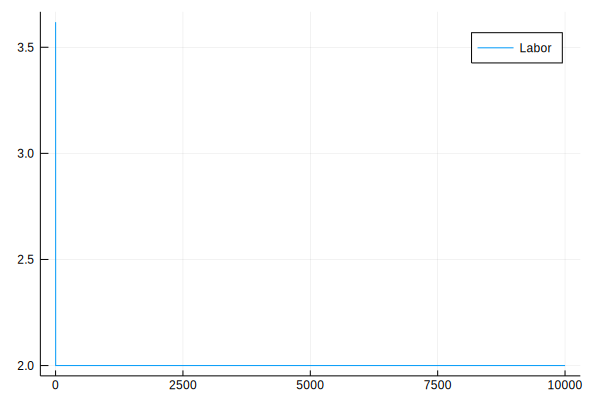

In [48]:
labels = "Labor"
plot(h,label = labels)

In [49]:
mean(h)

2.000161843956813

In [50]:
hss

1.0000000000003775

## Comparing the Methods

Below, we plot the Capital policy functions generate by each method using a full depreciation with exogenous labor calibration since we can also easily compare with the true function. We compare visually their accuracy, and we also time and verify the memory costs of each method.

In [1]:
using Plots

δ = 1    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0    #AR(1) constant term
ϕ = 0    #Labor parameter
γn= 0    #Population growth rate
γz= 0    #Productivitu growth rate

Xnneg = true #Non negative investment

true

In [23]:
include("Riccati.jl")
@time A,B,C,P ,F, F1,kss,hss = LQ(δ,β,ρ,σ,μ,ϕ,γn,γz);

  0.524565 seconds (642.33 k allocations: 31.479 MiB, 1.20% gc time)


In [22]:
#grid for k
K = 100 #number of gridpoints for capital
kmax = 10*kss # maximum value for k (set low if no productivity shocks!)
kmin = 1/10*kss #minimum value for k
#grid for z
Z = 40 #number of productivity states

include("run_VFI.jl")
@time VFI_V, VFI_policyk,VFI_policyh, k,h, z, Π = VFI(δ,θ,β,ρ,σ,μ,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg)



 62.330026 seconds (5.63 M allocations: 11.934 GiB, 1.10% gc time)


([-11.3009 -11.2815 … -10.5629 -10.5436; -11.2575 -11.2381 … -10.5195 -10.5002; … ; -9.87698 -9.85762 … -9.14195 -9.12313; -9.87471 -9.85535 … -9.13974 -9.12094], [45 45 … 74 75; 46 47 … 77 78; … ; 137 139 … 200 200; 137 139 … 200 200], [200 200 … 200 200; 200 200 … 200 200; … ; 200 200 … 200 200; 200 200 … 200 200], 0.01:0.0009547738693467337:0.2, 0.0:0.005025125628140704:1.0, [0.716531, 0.728885, 0.741452, 0.754235, 0.767239, 0.780467, 0.793923, 0.807611, 0.821535, 0.835699  …  1.1966, 1.21723, 1.23822, 1.25957, 1.28128, 1.30338, 1.32585, 1.34871, 1.37196, 1.39561], [0.411528 0.00943068 … 0.00763813 0.243522; 0.406832 0.00940591 … 0.00770087 0.247325; … ; 0.247325 0.00770087 … 0.00940591 0.406832; 0.243522 0.00763813 … 0.00943068 0.411528])

In [17]:
LQ_policyk = (A-B*F)[1,1]'.*k .+ (A-B*F)[1,2] * z[20]

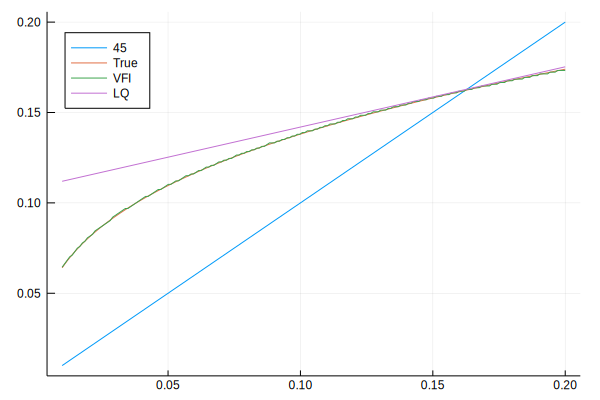

In [20]:
plot(k,[k,θ*β*z[20]*k.^(θ),k[VFI_policyk[:,20]],LQ_policyk],label = ["45","True","VFI","LQ"],legend=:topleft)
